### 1. Importing all the important libraries

In [ ]:
# Data handling libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime
import time
import random
from warnings import filterwarnings
from imageio import imread
from PIL import Image
import abc
from skimage.transform import resize
import cv2

# DL Model libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, History
from tensorflow.keras import optimizers
from keras import backend as K

# for Conv3D Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D

# for Conv2D + RNN Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GRU, TimeDistributed
from keras.applications.vgg16 import VGG16
from keras.applications import mobilenet
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM

# Specific conditions
filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format= 'svg'

plt.style.use('seaborn')

#### 1.1 Fixing random seeds

In [ ]:
random.seed(30)
tf.random.set_seed(30)

#### Getting the data



### 2. Getting the data

* The given dataset is uploaded in a googledrive folder, with url : https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL

In [ ]:
pip install googledrivedownloader

In [ ]:
# Specifying the url and directory for downloading the data
file_url = 'https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL'
file_id = file_url.split('id=')[-1]
current_dir = os.getcwd()
file_dir = current_dir +'\\'
file_name = 'Project_data.zip'

#### Unzipping the zip file from the google drive url and saving it in the current directory

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

# Downloading and unpacking the zip file
gdd.download_file_from_google_drive(file_id = file_id,
                                    dest_path = file_dir + file_name,
                                    unzip = True)
# Removing the zip file
os.remove(file_dir+file_name)

#### 2.1 Specifying directory for the data

In [ ]:
project_data_dir = os.path.join(current_dir, 'Project_data')

train_csv_dir = os.path.join(project_data_dir,'train.csv')
val_csv_dir = os.path.join(project_data_dir,'val.csv')

train_data_dir = os.path.join(project_data_dir, 'train')
val_data_dir = os.path.join(project_data_dir, 'val')

#### 2.2 Reading folder names from csv

In [ ]:
# Choosing permutation as we want to randomize only the output whithout changing the sequence in the original object
train_doc = np.random.permutation(open(train_csv_dir).readlines())
val_doc = np.random.permutation(open(val_csv_dir).readlines())

#### 2.2 Checking the count of folders in train and val

In [ ]:
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

#### 2.3 Specifying batch size and num of epochs

In [ ]:
batch_size = 32
num_epochs = 20
print ('# batch size =', batch_size)
print ('# epochs =', num_epochs)

#### 2.4 Inspecting the data

#### Listing the folders in train_doc

In [ ]:
train_doc

#### Viewing sample images from the folders

In [ ]:
# Viewing the image files in few folders

trial_1 = np.random.permutation(train_doc)
trial_path_1 = trial_1[0+(1*64)].split(';')[0]
trial_images_1 = os.listdir(os.path.join(train_data_dir,trial_path_1))

fig, ((ax1, ax2, ax3),\
    (ax4, ax5, ax6),\
    (ax7, ax8, ax9)) = plt.subplots(3,3, figsize = (10,10))

                          
for index, ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]):
    image = Image.open(os.path.join(train_data_dir, trial_path_1, trial_images_1[3*index]))
    ax.imshow(image)
    ax.axis('off')
    
plt.show()

In [ ]:
# Viewing the image files in few folders

trial_2 = np.random.permutation(train_doc)
trial_path_2 = trial_2[2+(1*64)].split(';')[0]
trial_images_2 = os.listdir(os.path.join(train_data_dir,trial_path_2))

fig, ((ax1, ax2, ax3),\
    (ax4, ax5, ax6),\
    (ax7, ax8, ax9)) = plt.subplots(3,3, figsize = (10,10))

                          
for index, ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]):
    image = Image.open(os.path.join(train_data_dir, trial_path_2, trial_images_2[3*index]))
    ax.imshow(image)
    ax.axis('off')
    
plt.show()

#### Resizing Image - Trial

In [ ]:
trial_img = Image.open(os.path.join(train_data_dir, trial_path_1, trial_images_1[1]))
trial_img

In [ ]:
trial_img_resized = trial_img.resize((84,84))

In [ ]:
trial_img_resized

#### Representing image as numpy array

In [ ]:
img = np.array(trial_img)
img

#### Checking the shape of the numpy array before and after resizing

In [ ]:
# Before resizing
imread(os.path.join(train_data_dir, trial_path_1, trial_images_1[1])).astype(np.float32).shape

In [ ]:
# After resizing
np.array(trial_img_resized).shape

#### 2.5 Function to
* Get values from history
* Plot history values
* Get best validation accuracy
* Get training accuracy at best validation accuracy
* Get epoch number
* Get parameter count

In [ ]:
def plot_results(model):
    
    model_history = model.history.history
    
    # storing accuracy values
    train_acc = model_history['categorical_accuracy']
    val_acc = model_history['val_categorical_accuracy']
    
    # storing loss values
    train_loss = model_history['loss']
    val_loss = model_history['val_loss']
    
    epochs_range = range(num_epochs)
    
    # plotting 
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(['Training', 'Validation'], loc = 'upper right', bbox_to_anchor = (1.4, 1.02))
    plt.title('Loss')

    plt.show()
    
    # returning train and val accuracy
    model_best_val_accuracy = round(max(val_acc),3)
    model_train_accuracy_at_best_val_accuracy = round(train_acc[val_acc.index(max(val_acc))],3)
    print('------------------')
    print(f'Highest validation accuracy                      = {round(max(val_acc),3)}')
    print(f'Training accuracy at highest validation accuracy = {round(train_acc[val_acc.index(max(val_acc))],3)}')
    print('------------------')
    
    return model_best_val_accuracy, model_train_accuracy_at_best_val_accuracy, num_epochs, model.count_params()


### 3. Generator for sourcing image data from the data directory

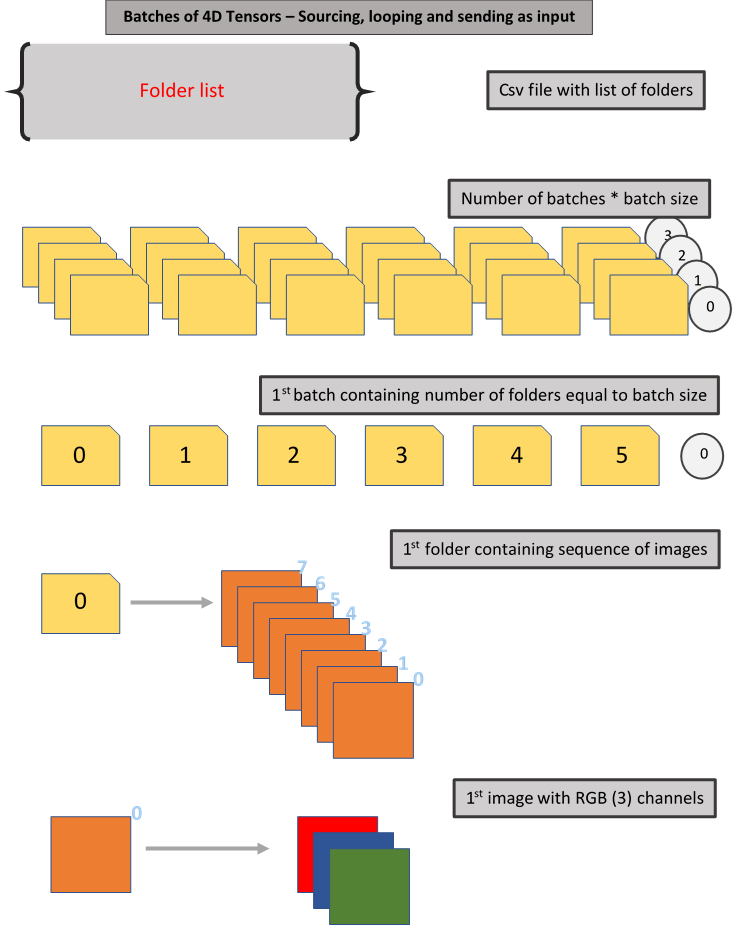

In [ ]:
def generator(source_path, folder_list, batch_size):
    print('Source path = ', source_path, '; batch size = ', batch_size)
    
    # we will try and make the model work in 18 images from each sequence
    # This means each 4D tensor becomes 18 * image height * image breadth * number of channels
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    
    # taking a set of 4D images at random permutation 
    # 4D image meaning sequences --> each sequence is in a different folder
    
    while True:

        folders = np.random.permutation(folder_list)
        num_batches = int(len(folders)/batch_size)

        # creating placeholders for the images and the labels
        # In each iteration, batch_size of 'batch_size' 4D tensor image is passed.
        # There are total of 5 labels

        for b_index in range(num_batches):
            batch_data = np.zeros((batch_size, len(img_idx), 84, 84, 3))
            batch_labels = np.zeros((batch_size, 5))

            # each batch is a collection of folders (many 4D Tensor)
            # each folder is a sequence of images (many 3D Tensor)
            # There are num_batches batch.
            # Each batch has batch_size folders
            # So in each batch, folder starts from 0 to batch_size.
            # For every item in folders, the first part when split at ';' is image, 2nd is class / type, 3rd is class label
            # listdir is to list the content of the folder

            for f_index in range(batch_size):
                folder_name = folders[f_index + (b_index * batch_size)].strip().split(';')[0]
                class_label = folders[f_index + (b_index * batch_size)].strip().split(';')[2]
                image_list = os.listdir(os.path.join(source_path, folder_name))

                # across the image list, we will choose and load only the images whose index match with idx_index
                for idx_index, idx_value in enumerate(img_idx):
                    image = Image.open(os.path.join(source_path, folder_name, image_list[idx_value]))
                    image = image.resize((84,84))
                    image = np.array(image, dtype = 'float32')

                    # normalizing the image
                    image = (image - image.min())/(image.max() - image.min())
                    
                    # since placeholder is set for each channel, we are also splitting the image as individual channel
                    
                    batch_data[f_index,idx_index,:,:,0] = image[:,:,0]
                    batch_data[f_index,idx_index,:,:,1] = image[:,:,0]
                    batch_data[f_index,idx_index,:,:,2] = image[:,:,0]

                batch_labels[f_index, int(class_label)] = 1
            yield batch_data, batch_labels
        
        # When the number of folders is less than the batch size
        # batch size placeholder will be replaced with the number of folders which are remaining
        if (len(folders)%batch_size) != 0:
            batch_data = np.zeros(((len(folders)%batch_size), len(img_idx), 84, 84, 3))
            batch_labels = np.zeros(((len(folders)%batch_size), 5))
            
            for f_index in range((len(folders)%batch_size)):
                folder_name = folders[f_index + (b_index * batch_size)].strip().split(';')[0]
                class_label = folders[f_index + (b_index * batch_size)].strip().split(';')[2]
                image_list = os.listdir(os.path.join(source_path, folder_name))

                # across the image list, we will choose and load only the images whose index match with idx_index
                for idx_index, idx_value in enumerate(img_idx):
                    image = Image.open(os.path.join(source_path, folder_name, image_list[idx_value]))
                    image = image.resize((84,84))
                    image = np.array(image, dtype = 'float32')

                    # normalizing the image
                    image = (image - image.min())/(image.max() - image.min())
                    
                    # since placeholder is set for each channel, we are also splitting the image as individual channel
                    
                    batch_data[f_index,idx_index,:,:,0] = image[:,:,0]
                    batch_data[f_index,idx_index,:,:,1] = image[:,:,1]
                    batch_data[f_index,idx_index,:,:,2] = image[:,:,2]

                batch_labels[f_index, int(class_label)] = 1
            yield batch_data, batch_labels

#### There are two primary motives in this project
* High accuracy
* Low execution time 

#### Finding model for best accuracy while trying to reduce execution time

### 4. Model1

#### 4.1 Structure

In [ ]:
model1 = Sequential()
model1.add(Conv3D(32, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,84,84,3)))
model1.add(Activation('elu'))
model1.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model1.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same'))
model1.add(Activation('elu'))
model1.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model1.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model1.add(Activation('elu'))
model1.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model1.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model1.add(Activation('elu'))
model1.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model1.add(Flatten())
model1.add(Dropout(0.25))
model1.add(Dense(512, activation='elu'))
model1.add(Dropout(0.25))
model1.add(Dense(5, activation='softmax'))

#### 4.2 Model1 Compilation - Optimizer and Loss function

In [ ]:
adam = optimizers.Adam(learning_rate = 0.001)
model1.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

#### 4.3 Sourcing the data

In [ ]:
# Initiating the iterable generators for train and validation 
train_generator = generator(train_data_dir, train_doc, batch_size)
val_generator = generator(val_data_dir, val_doc, batch_size)

#### 4.4 Storing model1 check points

In [ ]:
curr_dt_time = datetime.now()

In [ ]:
# Creating the model name based on runtime.
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

# if path does not exist, make new path
if not os.path.exists(model_name):
    os.mkdir(model_name)

# .h5 File name
filepath = model_name + 'model1-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# checkpoint to record val loss
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,\
                             save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

# reducing the learning rate if there is no reduction in gradient over epochs
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,\
                       verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)

# Also creating a history object to record all parameters over epochs
history = History()
# storing checkpoint and LR as callbacks list
callbacks_list = [checkpoint, LR, history]

#### 4.5 Steps per epoch

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

#### 4.6 Model1 Training

In [ ]:
# Timing the model runtime
model1_start_time = time.time()

In [ ]:
model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=2, 
                     callbacks=callbacks_list, validation_data=val_generator, 
                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
model1_exec_time = round((time.time() - model1_start_time), 6)
print(f"Model1 execution time is {model1_exec_time} seconds")

#### 4.7 Plotting recorded results and getting the accuracies

In [ ]:
model1_best_val_acc, model1_train_acc_at_best_val_acc,model1_num_epochs, model1_param_count = plot_results(model1)

### 5. model2

#### 5.1 Structure

Reducing the number of parameters by reducing the kernels used to check if it improves timing

In [ ]:
model2 = Sequential()
model2.add(Conv3D(32, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,84,84,3)))
model2.add(Activation('elu'))
model2.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model2.add(Conv3D(32, (3,3,3), strides=(1,1,1), padding='same'))
model2.add(Activation('elu'))
model2.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model2.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same'))
model2.add(Activation('elu'))
model2.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model2.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model2.add(Activation('elu'))
model2.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model2.add(Flatten())
model2.add(Dropout(0.25))
model2.add(Dense(512, activation='elu'))
model2.add(Dropout(0.25))
model2.add(Dense(5, activation='softmax'))

#### 5.2 Model Compilation - Optimizer and Loss function

In [ ]:
adam = optimizers.Adam(learning_rate = 0.001)
model2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

#### 5.3 Sourcing the data

In [ ]:
# Initiating the iterable generators for train and validation 
train_generator = generator(train_data_dir, train_doc, batch_size)
val_generator = generator(val_data_dir, val_doc, batch_size)

#### 5.4 Storing model2 check points

In [ ]:
curr_dt_time = datetime.now()

In [ ]:
# Creating the model name based on runtime.
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

# if path does not exist, make new path
if not os.path.exists(model_name):
    os.mkdir(model_name)

# .h5 File name
filepath = model_name + 'model2-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# checkpoint to record val loss
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,\
                             save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

# reducing the learning rate if there is no reduction in gradient over epochs
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,\
                       verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)

# Also creating a history object to record all parameters over epochs
history = History()
# storing checkpoint and LR as callbacks list
callbacks_list = [checkpoint, LR, history]

#### 5.5 Steps per epoch

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

#### 5.6 model2 Training

In [ ]:
# Timing the model runtime
model2_start_time = time.time()

In [ ]:
model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=2, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
model2_exec_time = round((time.time() - model2_start_time), 6)
print(f"Model2 execution time is {model2_exec_time} seconds")

#### 5.7 Plotting recorded results and getting the accuracies

In [ ]:
model2_best_val_acc, model2_train_acc_at_best_val_acc,model2_num_epochs, model2_param_count = plot_results(model2)

### 6. model3

Checking if reducing number of hidden layer by 1 reduces time taken for an epoch

#### 6.1 Structure

In [ ]:
model3 = Sequential()
model3.add(Conv3D(32, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,84,84,3)))
model3.add(Activation('elu'))
model3.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model3.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same'))
model3.add(Activation('elu'))
model3.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model3.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model3.add(Activation('elu'))
model3.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model3.add(Flatten())
model3.add(Dropout(0.25))
model3.add(Dense(512, activation='elu'))
model3.add(Dropout(0.25))
model3.add(Dense(5, activation='softmax'))

#### 6.2 Model Compilation - Optimizer and Loss function

In [ ]:
adam = optimizers.Adam(learning_rate = 0.001)
model3.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

#### 6.3 Sourcing the data

In [ ]:
# Initiating the iterable generators for train and validation 
train_generator = generator(train_data_dir, train_doc, batch_size)
val_generator = generator(val_data_dir, val_doc, batch_size)

#### 6.4 Storing model3 check points

In [ ]:
curr_dt_time = datetime.now()

In [ ]:
# Creating the model name based on runtime.
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

# if path does not exist, make new path
if not os.path.exists(model_name):
    os.mkdir(model_name)

# .h5 File name
filepath = model_name + 'model3-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# checkpoint to record val loss
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,\
                             save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

# reducing the learning rate if there is no reduction in gradient over epochs
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,\
                       verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)

# Also creating a history object to record all parameters over epochs
history = History()
# storing checkpoint and LR as callbacks list
callbacks_list = [checkpoint, LR, history]

#### 6.5 Steps per epoch

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

#### 6.6 model3 Training

In [ ]:
# Timing the model runtime
model3_start_time = time.time()

In [ ]:
model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=2, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
model3_exec_time = round((time.time() - model3_start_time), 6)
print(f"Model3 execution time is {model3_exec_time} seconds")

#### 6.7 Plotting recorded results and getting the accuracies

In [ ]:
model3_best_val_acc, model3_train_acc_at_best_val_acc,model3_num_epochs, model3_param_count = plot_results(model3)

### 7. Model4

Since the parameter reduction did not do substantial improvement towards time taken, but reduced accuracy immensely, model structure shall be retained the same as model1, but will change batch size to __16__.

In [ ]:
batch_size = 16
print('# batch size =', batch_size)

#### 7.1 Structure

In [ ]:
model4 = Sequential()
model4.add(Conv3D(32, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,84,84,3)))
model4.add(Activation('elu'))
model4.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model4.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same'))
model4.add(Activation('elu'))
model4.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model4.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model4.add(Activation('elu'))
model4.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model4.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model4.add(Activation('elu'))
model4.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model4.add(Flatten())
model4.add(Dropout(0.25))
model4.add(Dense(512, activation='elu'))
model4.add(Dropout(0.25))
model4.add(Dense(5, activation='softmax'))

#### 7.2 model4 Compilation - Optimizer and Loss function

In [ ]:
adam = optimizers.Adam(learning_rate = 0.001)
model4.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

#### 7.3 Sourcing the data

In [ ]:
# Initiating the iterable generators for train and validation 
train_generator = generator(train_data_dir, train_doc, batch_size)
val_generator = generator(val_data_dir, val_doc, batch_size)

#### 7.4 Storing model4 check points

In [ ]:
curr_dt_time = datetime.now()

In [ ]:
# Creating the model name based on runtime.
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

# if path does not exist, make new path
if not os.path.exists(model_name):
    os.mkdir(model_name)

# .h5 File name
filepath = model_name + 'model4-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# checkpoint to record val loss
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,\
                             save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

# reducing the learning rate if there is no reduction in gradient over epochs
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,\
                       verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)

# Also creating a history object to record all parameters over epochs
history = History()
# storing checkpoint and LR as callbacks list
callbacks_list = [checkpoint, LR, history]

#### 7.5 Steps per epoch

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

#### 7.6 model4 Training

In [ ]:
# Timing the model runtime
model4_start_time = time.time()

In [ ]:
model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=2, 
                     callbacks=callbacks_list, validation_data=val_generator, 
                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
model4_exec_time = round((time.time() - model4_start_time), 6)
print(f"Model4 execution time is {model4_exec_time} seconds")

#### 7.7 Plotting recorded results and getting the accuracies

In [ ]:
model4_best_val_acc, model4_train_acc_at_best_val_acc,model4_num_epochs, model4_param_count = plot_results(model4)

### 8. model5

The epochs from 15 to 20 are not reducing losses anymore in model4, and accuracy gain is marginal. So will change num_epochs to 15.

In [ ]:
num_epochs = 15
print('# num epochs =', num_epochs)

#### 8.1 Structure

In [ ]:
model5 = Sequential()
model5.add(Conv3D(32, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,84,84,3)))
model5.add(Activation('elu'))
model5.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model5.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same'))
model5.add(Activation('elu'))
model5.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model5.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model5.add(Activation('elu'))
model5.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model5.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model5.add(Activation('elu'))
model5.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model5.add(Flatten())
model5.add(Dropout(0.25))
model5.add(Dense(512, activation='elu'))
model5.add(Dropout(0.25))
model5.add(Dense(5, activation='softmax'))

#### 8.2 model5 Compilation - Optimizer and Loss function

In [ ]:
adam = optimizers.Adam(learning_rate = 0.001)
model5.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

#### 8.3 Sourcing the data

In [ ]:
# Initiating the iterable generators for train and validation 
train_generator = generator(train_data_dir, train_doc, batch_size)
val_generator = generator(val_data_dir, val_doc, batch_size)

#### 8.4 Storing model5 check points

In [ ]:
curr_dt_time = datetime.now()

In [ ]:
# Creating the model name based on runtime.
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

# if path does not exist, make new path
if not os.path.exists(model_name):
    os.mkdir(model_name)

# .h5 File name
filepath = model_name + 'model5-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# checkpoint to record val loss
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,\
                             save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

# reducing the learning rate if there is no reduction in gradient over epochs
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,\
                       verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)

# Also creating a history object to record all parameters over epochs
history = History()
# storing checkpoint and LR as callbacks list
callbacks_list = [checkpoint, LR, history]

#### 8.5 Steps per epoch

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

#### 8.6 model5 Training

In [ ]:
# Timing the model runtime
model5_start_time = time.time()

In [ ]:
model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=2, 
                     callbacks=callbacks_list, validation_data=val_generator, 
                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
model5_exec_time = round((time.time() - model5_start_time), 6)
print(f"Model5 execution time is {model5_exec_time} seconds")

#### 8.7 Plotting recorded results and getting the accuracies

In [ ]:
model5_best_val_acc, model5_train_acc_at_best_val_acc,model5_num_epochs, model5_param_count = plot_results(model5)

### 9. Model6

#### 9.1 Structure

Since the drop in accuracy was only 0.02, using the reduced parameters model, with batch size as 16 and epochs as 15

In [ ]:
model6 = Sequential()
model6.add(Conv3D(32, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,84,84,3)))
model6.add(Activation('elu'))
model6.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model6.add(Conv3D(32, (3,3,3), strides=(1,1,1), padding='same'))
model6.add(Activation('elu'))
model6.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model6.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same'))
model6.add(Activation('elu'))
model6.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model6.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model6.add(Activation('elu'))
model6.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model6.add(Flatten())
model6.add(Dropout(0.25))
model6.add(Dense(512, activation='elu'))
model6.add(Dropout(0.25))
model6.add(Dense(5, activation='softmax'))

#### 9.2 Model Compilation - Optimizer and Loss function

In [ ]:
adam = optimizers.Adam(learning_rate = 0.001)
model6.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model6.summary())

#### 9.3 Sourcing the data

In [ ]:
# Initiating the iterable generators for train and validation 
train_generator = generator(train_data_dir, train_doc, batch_size)
val_generator = generator(val_data_dir, val_doc, batch_size)

#### 9.4 Storing model6 check points

In [ ]:
curr_dt_time = datetime.now()

In [ ]:
# Creating the model name based on runtime.
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

# if path does not exist, make new path
if not os.path.exists(model_name):
    os.mkdir(model_name)

# .h5 File name
filepath = model_name + 'model6-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# checkpoint to record val loss
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,\
                             save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

# reducing the learning rate if there is no reduction in gradient over epochs
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,\
                       verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)

# Also creating a history object to record all parameters over epochs
history = History()
# storing checkpoint and LR as callbacks list
callbacks_list = [checkpoint, LR, history]

#### 9.5 Steps per epoch

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

#### 9.6 model6 Training

In [ ]:
# Timing the model runtime
model6_start_time = time.time()

In [ ]:
model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=2, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
model6_exec_time = round((time.time() - model6_start_time), 6)
print(f"Model6 execution time is {model6_exec_time} seconds")

#### 9.7 Plotting recorded results and getting the accuracies

In [ ]:
model6_best_val_acc, model6_train_acc_at_best_val_acc,model6_num_epochs, model6_param_count = plot_results(model6)

### 10. Model7

#### 10.1 Structure

 Making the following changes to the model and compilation.
* Reducing the model structure as 16, 32, 64, 128
* learning rate from 0.001 to 0.0012
* LR reduce on Plateau - factor from 0.5 to 0.7 and patience from 2 to 1
* Increase dropout from 0.25 to 0.4 to reduce overfitting

In [ ]:
model7 = Sequential()
model7.add(Conv3D(16, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,84,84,3)))
model7.add(Activation('elu'))
model7.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model7.add(Conv3D(32, (3,3,3), strides=(1,1,1), padding='same'))
model7.add(Activation('elu'))
model7.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model7.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same'))
model7.add(Activation('elu'))
model7.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model7.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model7.add(Activation('elu'))
model7.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model7.add(Flatten())
model7.add(Dropout(0.4))
model7.add(Dense(512, activation='elu'))
model7.add(Dropout(0.4))
model7.add(Dense(5, activation='softmax'))

#### 10.2 Model Compilation - Optimizer and Loss function

In [ ]:
adam = optimizers.Adam(learning_rate = 0.0012)
model7.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model7.summary())

#### 10.3 Sourcing the data

In [ ]:
# Initiating the iterable generators for train and validation 
train_generator = generator(train_data_dir, train_doc, batch_size)
val_generator = generator(val_data_dir, val_doc, batch_size)

#### 10.4 Storing model7 check points

In [ ]:
curr_dt_time = datetime.now()

In [ ]:
# Creating the model name based on runtime.
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

# if path does not exist, make new path
if not os.path.exists(model_name):
    os.mkdir(model_name)

# .h5 File name
filepath = model_name + 'model7-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# checkpoint to record val loss
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,\
                             save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

# reducing the learning rate if there is no reduction in gradient over epochs
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=1,\
                       verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)

# Also creating a history object to record all parameters over epochs
history = History()
# storing checkpoint and LR as callbacks list
callbacks_list = [checkpoint, LR, history]

#### 10.5 Steps per epoch

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

#### 10.6 model7 Training

In [ ]:
# Timing the model runtime
model7_start_time = time.time()

In [ ]:
model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=2, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
model7_exec_time = round((time.time() - model7_start_time), 6)
print(f"Model7 execution time is {model7_exec_time} seconds")

#### 70.7 Plotting recorded results and getting the accuracies

In [ ]:
model7_best_val_acc, model7_train_acc_at_best_val_acc,model7_num_epochs, model7_param_count = plot_results(model7)

### 11. model8

#### 11.1 Structure

 Making the following changes to the model and compilation.
* Increasing the model structure as 16, 32, 64, 128, 256
* Maintaining learning rate as 0.0012
* LR reduce on Plateau - factor as 0.7 and patience as 1
* Increase dropout from 0.4 to 0.5 to reduce overfitting

In [ ]:
model8 = Sequential()
model8.add(Conv3D(16, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,84,84,3)))
model8.add(Activation('elu'))
model8.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model8.add(Conv3D(32, (3,3,3), strides=(1,1,1), padding='same'))
model8.add(Activation('elu'))
model8.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model8.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same'))
model8.add(Activation('elu'))
model8.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model8.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model8.add(Activation('elu'))
model8.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model8.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model8.add(Activation('elu'))
model8.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same'))

model8.add(Flatten())
model8.add(Dropout(0.5))
model8.add(Dense(512, activation='elu'))
model8.add(Dropout(0.5))
model8.add(Dense(5, activation='softmax'))

#### 11.2 Model Compilation - Optimizer and Loss function

In [ ]:
adam = optimizers.Adam(learning_rate = 0.0012)
model8.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model8.summary())

#### 11.3 Sourcing the data

In [ ]:
# Initiating the iterable generators for train and validation 
train_generator = generator(train_data_dir, train_doc, batch_size)
val_generator = generator(val_data_dir, val_doc, batch_size)

#### 11.4 Storing model8 check points

In [ ]:
curr_dt_time = datetime.now()

In [ ]:
# Creating the model name based on runtime.
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

# if path does not exist, make new path
if not os.path.exists(model_name):
    os.mkdir(model_name)

# .h5 File name
filepath = model_name + 'model8-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# checkpoint to record val loss
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,\
                             save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

# reducing the learning rate if there is no reduction in gradient over epochs
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=1,\
                       verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)

# Also creating a history object to record all parameters over epochs
history = History()
# storing checkpoint and LR as callbacks list
callbacks_list = [checkpoint, LR, history]

#### 11.5 Steps per epoch

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

#### 11.6 model8 Training

In [ ]:
# Timing the model runtime
model8_start_time = time.time()

In [ ]:
model8.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=2, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
model8_exec_time = round((time.time() - model8_start_time), 6)
print(f"Model8 execution time is {model8_exec_time} seconds")

#### 11.7 Plotting recorded results and getting the accuracies

In [ ]:
model8_best_val_acc, model8_train_acc_at_best_val_acc,model8_num_epochs, model8_param_count = plot_results(model8)

### 12. model9 - Conv2D + RNN Model

#### 12.1 Structure

* Using VGG16 pretrained model for Conv2D and therefore will lock the layers from training.
* Then using GRU model for sequence learning

In [ ]:
# Structuring the transferred CNN model for image feature extraction
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(84,84,3)) 
x = base_model.output
x = Flatten()(x)
#x.add(Dropout(0.5))
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)

# Freezing the weights
for layer in base_model.layers:
    layer.trainable = False


model9 = Sequential()
model9.add(TimeDistributed(conv_model, input_shape=(18,84,84,3)))
model9.add(GRU(32, return_sequences=True))
model9.add(GRU(16))
model9.add(Dropout(0.5))
model9.add(Dense(8, activation='relu'))
model9.add(Dense(5, activation='softmax'))

#### 12.2 Model Compilation - Optimizer and Loss function

In [ ]:
adam = optimizers.Adam(learning_rate = 0.001)
model9.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model9.summary())

#### 12.3 Sourcing the data

In [ ]:
# Setting the batch size and num_epochs
batch_size = 16
num_epochs = 30
print('# batch size = ', batch_size)
print('# number of epochs = ', num_epochs)
# Initiating the iterable generators for train and validation 
train_generator = generator(train_data_dir, train_doc, batch_size)
val_generator = generator(val_data_dir, val_doc, batch_size)

#### 12.4 Storing model9 check points

In [ ]:
curr_dt_time = datetime.now()

In [ ]:
# Creating the model name based on runtime.
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

# if path does not exist, make new path
if not os.path.exists(model_name):
    os.mkdir(model_name)

# .h5 File name
filepath = model_name + 'model9-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# checkpoint to record val loss
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,\
                             save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

# reducing the learning rate if there is no reduction in gradient over epochs
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,\
                       verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)

# Also creating a history object to record all parameters over epochs
history = History()
# storing checkpoint and LR as callbacks list
callbacks_list = [checkpoint, LR, history]

#### 12.5 Steps per epoch

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

#### 12.6 model9 Training

In [ ]:
# Timing the model runtime
model9_start_time = time.time()

In [ ]:
model9.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=2, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
model9_exec_time = round((time.time() - model9_start_time), 6)
print(f"model9 execution time is {model9_exec_time} seconds")

#### 12.7 Plotting recorded results and getting the accuracies

In [ ]:
model9_best_val_acc, model9_train_acc_at_best_val_acc, model9_num_epochs, model9_param_count = plot_results(model9)

#### The above model did not give impressive results. 

Will design a generator, and structure a manual CNN and then an LSTM model.

### 13. Generator

In [ ]:
class ModelBuilder(metaclass = abc.ABCMeta):
    
    def initialize_path(self,project_data_dir):
        self.train_doc = np.random.permutation(open(train_csv_dir).readlines())
        self.val_doc = np.random.permutation(open(val_csv_dir).readlines())
        self.train_path = train_data_dir
        self.val_path =  val_data_dir
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
     
    
    def initialize_image_properties(self,image_height=84,image_width=84):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
     
    
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
    
    
    def train_model(self, model, model_num):
        
        model_num = 'model' + str(model_num)
        
        train_generator = generator(self.train_path, self.train_doc, self.batch_size)
        val_generator = generator(self.val_path, self.val_doc, batch_size)

        model_name = 'model_init' + '_' + str(datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + model_num +'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,\
                                     save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

        # reducing the learning rate if there is no reduction in gradient over epochs
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=1,\
                               verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
        
        history = History()
        
        callbacks_list = [checkpoint, LR, history]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
        
        model_start_time = time.time()
        
        model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=2, 
                                      callbacks=callbacks_list, validation_data=val_generator, 
                                      validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        
        model_exec_time = round((time.time() - model_start_time), 6)
        print(f"model execution time is {model_exec_time} seconds")
        
        model_history = model.history.history
    
        # storing accuracy values
        train_acc = model_history['categorical_accuracy']
        val_acc = model_history['val_categorical_accuracy']

        # storing loss values
        train_loss = model_history['loss']
        val_loss = model_history['val_loss']

        epochs_range = range(len(train_acc))

        # plotting 
        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, train_acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.title('Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, train_loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(['Training', 'Validation'], loc = 'upper right', bbox_to_anchor = (1.4, 1.02))
        plt.title('Loss')

        plt.show()

        # returning train and val accuracy
        model_best_val_accuracy = round(max(val_acc),3)
        model_train_accuracy_at_best_val_accuracy = round(train_acc[val_acc.index(max(val_acc))],3)
        print('------------------')
        print(f'Highest validation accuracy                      = {round(max(val_acc),3)}')
        print(f'Training accuracy at highest validation accuracy = {round(train_acc[val_acc.index(max(val_acc))],3)}')
        print('------------------')

        return model_best_val_accuracy, model_train_accuracy_at_best_val_accuracy, num_epochs, model.count_params(), model_exec_time
        
    @abc.abstractmethod
    def define_model(self):
        pass

### 14. Model10 (CNN - LSTM Model)

#### 14.1 Model Class

* Using VGG16 pretrained model for Conv2D and therefore will lock the layers from training.
* Then using GRU model for sequence learning

In [ ]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
       # model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        adam = optimizers.Adam()
        model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

#### 14.2 Model Structure

In [ ]:
model10=RNNCNN1()
model10.initialize_path(project_folder)
model10.initialize_image_properties(image_height=84,image_width=84)
model10.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
model10_model=model10.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
model10_model.summary()

#### 14.3 Model Training, Plotting and retrieving accuracies

In [ ]:
model10_best_val_acc, model10_train_acc_at_best_val_acc, model10_num_epochs, model10_param_count, model10_exec_time = model10.train_model(model10_model, model_num = 10)

There is not sufficient validation accuracy and this model is clearly overfitting.

### 15. Model11 (CNN - LSTM Model with Transfer Learning)

#### 15.1 Model Class

* Using Mobilenet pretrained model for Conv2D and therefore will lock the layers from training.
* Then using LSTM cells for sequence learning

In [ ]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        adam = optimizers.Adam()
        model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

#### 15.2 Model Structure

In [ ]:
model11=RNNCNN_TL()
model11.initialize_path(project_folder)
model11.initialize_image_properties(image_height=84,image_width=84)
model11.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
model11_model=model11.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
model11_model.summary()

#### 15.3 Model Training, Plotting and retrieving the accuracies

In [ ]:
model11_best_val_acc, model11_train_acc_at_best_val_acc, model11_num_epochs, model11_param_count, model11_exec_time = model11.train_model(model11_model, model_num = 11)

Checking if the accuracy can be improved by unlocking the layers from transferred model for training again

### 16. model12 (CNN - GRU Model with Transfer Learning and retraining)

#### 16.1 Model Class

* Using mobilenet pretrained model for Conv2D and training the layers again
* Then using GRU model for sequence learning
* Setting epochs to 15

In [ ]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilder):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

#### 16.2 Model Structure

In [ ]:
model12=RNNCNN_TL2()
model12.initialize_path(project_folder)
model12.initialize_image_properties(image_height=84,image_width=84)
model12.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=15)
model12_model=model12.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
model12_model.summary()

#### 16.3 Model Training, Plotting and retrieving accuracies

In [ ]:
model12_best_val_acc, model12_train_acc_at_best_val_acc, model12_num_epochs, model12_param_count, model12_exec_time = model12.train_model(model12_model, model_num = 12)

### 17. Summary

#### 17.1 Dataframe of models

In [ ]:
model_list = ['model'+str(i) for i in range(1, 13)]

params_count_list = [model1_param_count, model2_param_count, model3_param_count, model4_param_count,
                     model5_param_count, model6_param_count, model7_param_count, model8_param_count,
                     model9_param_count, model10_param_count, model11_param_count, model12_param_count]

num_of_epochs = [model1_num_epochs, model2_num_epochs, model3_num_epochs, model4_num_epochs,
                model5_num_epochs, model6_num_epochs, model7_num_epochs, model8_num_epochs,
                model9_num_epochs, model10_num_epochs, model11_num_epochs, model12_num_epochs]

model_exec_time = [model1_exec_time, model2_exec_time, model3_exec_time, model4_exec_time,
                  model5_exec_time, model6_exec_time, model7_exec_time, model8_exec_time, 
                  model9_exec_time, model10_exec_time, model11_exec_time, model12_exec_time]

model_highest_val_acc = [model1_best_val_acc, model2_best_val_acc, model3_best_val_acc, model4_best_val_acc,
                        model5_best_val_acc, model6_best_val_acc, model7_best_val_acc, model8_best_val_acc,
                        model9_best_val_acc, model10_best_val_acc, model11_best_val_acc, model12_best_val_acc]

train_acc_at_highest_val_acc = [model1_train_acc_at_best_val_acc, model2_train_acc_at_best_val_acc,
                                model3_train_acc_at_best_val_acc, model4_train_acc_at_best_val_acc,
                                model5_train_acc_at_best_val_acc, model6_train_acc_at_best_val_acc,
                                model7_train_acc_at_best_val_acc, model8_train_acc_at_best_val_acc,
                                model9_train_acc_at_best_val_acc, model10_train_acc_at_best_val_acc,
                                model11_train_acc_at_best_val_acc, model12_train_acc_at_best_val_acc]

import pandas as pd

model_specs = pd.DataFrame({'Model' : model_list,
                            'paramseter_count' : params_count_list,
                            'Best_validation_accuracy' : model_highest_val_acc,
                            'Train_accuracy' : train_acc_at_highest_val_acc,
                            'Epoch_count' : num_of_epochs,
                            'Execution_time' : model_exec_time
                            })

model_specs['Exec_time_per_epoch'] = (model_specs['Execution_time']/model_specs['Epoch_count']).round(6)

model_specs.sort_values('Execution_time')

***
#### The following are the observations and conclusion from the case study

* Model12 is the best model with overall high accuracy - 99 for train and 94 for validation.
* Model12 has the lowest execution time with excellent validation accuracy.
* Model12 therefore shall be the final model and the highest validation accuracy weights saved in its corresponding .h5 file shall be uploaded for deployment.
***